In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, random ,cv2, glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.preprocessing.image
import matplotlib.pyplot as plt
import argparse
import time
import zipfile
import io

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Unzipping dataset

In [ ]:
with zipfile.ZipFile("drive/My Drive/MaskNoMask_iter_2.zip", "r") as zf:
  zf.extractall()

In [ ]:
dataPath = "MaskNoMask_iter_2/"
utilPath = "drive/My Drive/utils/"

# Yolo v3 stage

Generates the dataset for the next steps with the mask detector.

In [ ]:
# load the COCO class labels our YOLO model was trained on
labelsPath = (utilPath+"coco.names")
LABELS = open(labelsPath).read().strip().split("\n")
print(LABELS)

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                           dtype="uint8")

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
# derive the paths to the YOLO weights and model configuration
weightsPath = (utilPath + "yolov3.weights")
configPath = (utilPath + "yolov3.cfg")

In [ ]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [ ]:
# Get all image paths
imgs = glob.glob(dataPath+'/*')
datasetPath = "ClassifierDataset/"
#os.mkdir("ClassifierDataset")

In [ ]:
len(imgs)

1986

In [ ]:
# determine output layer names
ln = net.getLayerNames()
ln = [ln[n[0] - 1] for n in net.getUnconnectedOutLayers()]

for i in imgs:
  # Load Image and save Dimensions
  name = i.split("/")[-1][:-4]
  image = cv2.imread(i)
  (H, W) = image.shape[:2]

  # Blob image and obtain scores
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  start = time.time()
  layerOutputs = net.forward(ln)
  end = time.time()
  print("{} precessed in {} seconds".format(name, end-start))

  # Initialie variables to save detections
  boxes = []
  confidences = []
  classIDs = []

  # loop over each of the layer outputs
  for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
      # extract the class ID and confidence (i.e., probability)
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]

      # filter out weak predictions 
      if confidence > 0.80 and classID == 0:
          # scale coordinates to the realtive size of the image
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # Derive the top corner of the Bounding Box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))

          # update image results
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)

  # Suppress weak, overlapping bounding boxes
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.3)
  print(boxes)

  # ensure at least one detection exists
  if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
      # extract the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])
      # Save Portion of the image corresponding to the person
      cv2.imwrite(datasetPath+name+'_'+str(i)+'.jpg',image[max(y,0):min(y+h,H), max(x,0):min(x+w,W)])



1289332228648865793 precessed in 1.8004345893859863 seconds
[[24, -6, 526, 548], [555, 79, 386, 458], [769, 200, 191, 205]]
1289387950539780096 precessed in 1.7958707809448242 seconds
[[96, 401, 242, 302], [667, 374, 258, 344], [334, 477, 222, 229], [4, 60, 98, 283], [199, 53, 113, 236], [361, 71, 79, 238], [418, 51, 89, 302], [752, 43, 131, 303], [493, 70, 46, 285], [101, 395, 222, 323], [688, 366, 220, 358], [355, 465, 183, 253], [706, 790, 126, 226]]
1289458552487084032 precessed in 1.8022816181182861 seconds
[[673, 79, 198, 412], [48, 112, 242, 457], [791, 94, 222, 476], [396, 142, 226, 501], [32, 125, 52, 81], [400, 93, 87, 208], [555, 58, 85, 285], [215, 94, 79, 249], [618, 79, 124, 281], [256, 107, 133, 344], [738, 104, 126, 344], [-4, 186, 98, 336], [34, 126, 39, 82], [-1, 138, 32, 72]]
1289427318570545154 precessed in 1.8243508338928223 seconds
[[86, 60, 872, 495], [-3, 97, 255, 496]]
1289343598127919105 precessed in 1.7942378520965576 seconds
[[8, 66, 187, 327], [183, 33, 377

In [ ]:
# Download Dataset to annotate
from google.colab import files
!zip -r classifierDataset.zip ClassifierDataset
files.download(classifierDataset.zip)

Output streaming troncato alle ultime 5000 righe.
  adding: ClassifierDataset/1289463986908405763_0.jpg (deflated 1%)
  adding: ClassifierDataset/1289328257767059456_0.jpg (deflated 1%)
  adding: ClassifierDataset/1289457938633912321_0.jpg (deflated 1%)
  adding: ClassifierDataset/1289449667705487360_2.jpg (deflated 1%)
  adding: ClassifierDataset/1289319932769923073_0.jpg (deflated 2%)
  adding: ClassifierDataset/1289455129171619841_8.jpg (deflated 7%)
  adding: ClassifierDataset/1289379585885237249_0.jpg (deflated 1%)
  adding: ClassifierDataset/1289434073866280962_5.jpg (deflated 6%)
  adding: ClassifierDataset/1289342578530439168_8.jpg (deflated 11%)
  adding: ClassifierDataset/1289377170549350400_7.jpg (deflated 3%)
  adding: ClassifierDataset/1289442935751114752_7.jpg (deflated 8%)
  adding: ClassifierDataset/1289340465318264834_1.jpg (deflated 0%)
  adding: ClassifierDataset/1289390525431181313_2.jpg (deflated 7%)
  adding: ClassifierDataset/1289312100846731264_4.jpg (deflated 5

NameError: ignored

# Use the new dataset to train a classifier 

Use an Xception model to classify the annotated images from the generated dataset.

In [ ]:
# Import annotated images from zip file
with zipfile.ZipFile("drive/My Drive/Dataset.zip", "r") as zip:
  zip.extractall()

In [ ]:
# Dataset Generation from Directory

bSize = 32 
seeed = 12345
eps = 50

rows = 300
cols = 300
channels = 3

path = "Dataset"

# Define the generator
datagen = ImageDataGenerator(
    rotation_range = 60,
    rescale=1./ 255,
    shear_range= 0.2,
    brightness_range = [0.5,1.0],
    zoom_range= 0.5,
    horizontal_flip=True,
    validation_split = 0.2
)

train = datagen.flow_from_directory(
    directory = path,
    target_size = (rows, cols),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = bSize,
    subset = 'training'
)

val = datagen.flow_from_directory(
    directory = path,
    target_size = (rows, cols),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = bSize,
    subset = 'validation'
)

Found 4560 images belonging to 2 classes.
Found 1139 images belonging to 2 classes.


Learning rate per epoch:


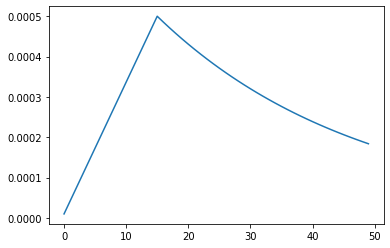

In [ ]:
EPOCHS = 50

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005 
rampup_epochs = 15
sustain_epochs = 0
exp_decay = .97

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
# Import pre trained model
from keras.applications import Xception

def create_model():
  pretrained_model = Xception(input_shape=(rows, cols, channels), include_top=False, weights='imagenet')
  pretrained_model.trainable = True
  model = Sequential()
  model.add(pretrained_model)
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
  )
  return model

# creating the model in the TPUStrategy scope means we will train the model on the TPU
model = create_model()

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,881,981
Trainable params: 20,827,453
Non

In [ ]:
# Training
history = model.fit(train, steps_per_epoch=4560/bSize, epochs=eps, verbose=1, validation_data=val, callbacks = [lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
143/142 [==============================] - 205s 1s/step - loss: 0.6954 - accuracy: 0.5254 - val_loss: 0.6727 - val_accuracy: 0.5645

Epoch 00002: LearningRateScheduler reducing learning rate to 4.266666666666666e-05.
Epoch 2/50
143/142 [==============================] - 205s 1s/step - loss: 0.5657 - accuracy: 0.7232 - val_loss: 0.4750 - val_accuracy: 0.7814

Epoch 00003: LearningRateScheduler reducing learning rate to 7.533333333333333e-05.
Epoch 3/50
143/142 [==============================] - 204s 1s/step - loss: 0.4389 - accuracy: 0.7914 - val_loss: 0.3768 - val_accuracy: 0.8341

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000108.
Epoch 4/50
143/142 [==============================] - 206s 1s/step - loss: 0.3562 - accuracy: 0.8432 - val_loss: 0.3842 - val_accuracy: 0.8130

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00014066666666666665.
Epoch 5/50
143/142 [===========

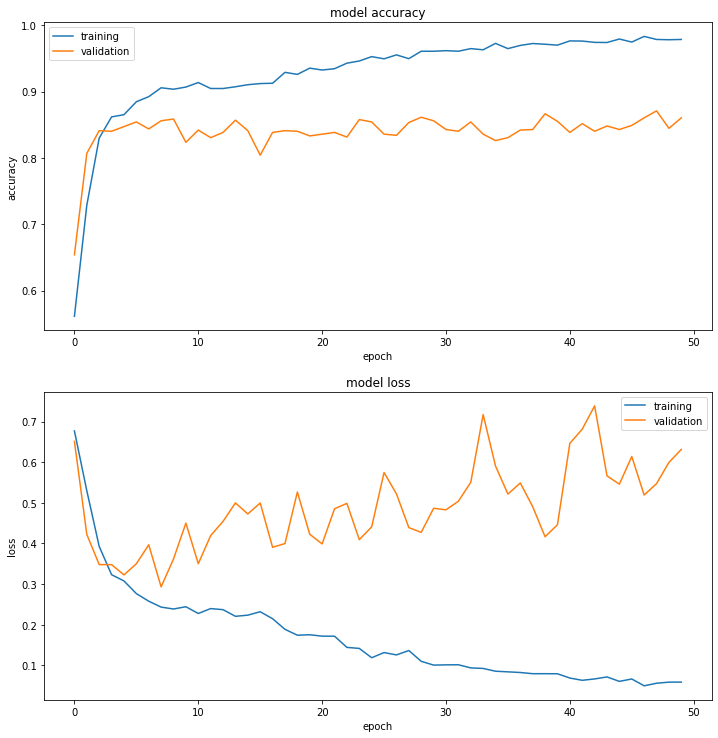

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# Saving Model weights and configuration
import json

model.save_weights("Weights.h5")
modelJson = model.to_json()

with open("config.json", "w") as file:
    json.dump(modelJson, file)

# Utilization on the initial dataset of 26k tweets

For each image, the yolo stage will return the people that are present in it.
Then, the Xception stage will detemrine whether or not each one of them is wearing a mask.
